# Task 2.1 & 2.2: Matching Volatility and Mismatched Volatility

Simulator setup complete!


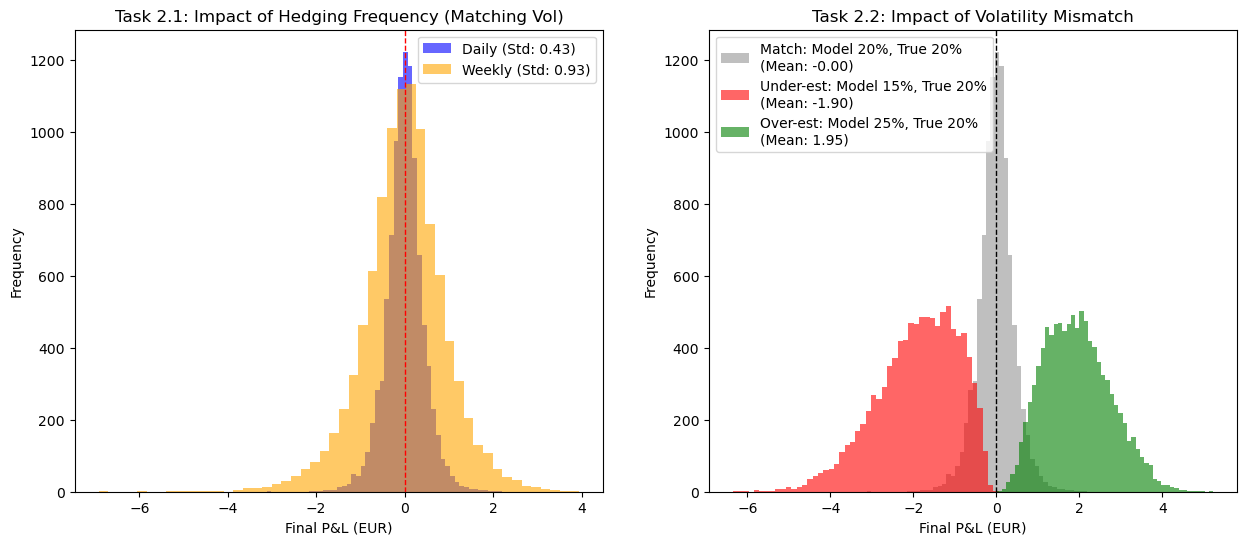

In [25]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# ==========================================
# Simulator setup
# ==========================================
S0 = 100.0      # Current stock price
K = 99.0        # Strike price
r = 0.06        # Risk-free interest rate 6%
T = 1.0         # Maturity 1 year
N_PATHS = 10000 # Number of Monte Carlo simulation paths (using vectorization to run 10,000 parallel paths at once)

def bs_call_price_delta(S, K, tau, r, sigma):
    """
    Calculate Black-Scholes call option price and Delta
    tau: Time to maturity (T - t)
    """
    # Avoid division by zero error at maturity t=T when tau=0
    tau = np.maximum(tau, 1e-10) 
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    delta = norm.cdf(d1)
    
    return price, delta

def run_hedging_simulation(steps, sigma_path, sigma_model):
    """
    Execute Euler method hedging simulation 
    steps: Number of hedging steps (e.g., daily steps=252, weekly steps=52)
    sigma_path: Volatility for generating the true stock price path
    sigma_model: Volatility used to calculate the BS Delta
    """
    dt = T / steps
    
    # Initialize stock price array, all 10,000 paths start at S0
    S = np.full(N_PATHS, S0)
    
    # --- t=0 Initial position setup ---
    # We short the option (receive option premium C0) and set up the replicating hedge portfolio V
    C0, current_delta = bs_call_price_delta(S, K, T, r, sigma_model)
    
    # Initial total value of the portfolio equals the premium received from selling the option
    V = np.copy(C0) 
    # We immediately buy current_delta shares of stock, and put the remaining cash into bank account B to earn interest
    B = V - current_delta * S 
    
    # --- Start time step iteration (Euler method simulation) ---
    for i in range(1, steps + 1):
        t = i * dt
        tau = T - t # Remaining time to maturity
        
        # 1. Euler step: Generate new stock prices 
        Z = np.random.standard_normal(N_PATHS)
        S = S + r * S * dt + sigma_path * S * np.sqrt(dt) * Z
        
        # 2. Portfolio value update: Bank account accrues interest, stock prices change
        B = B * np.exp(r * dt) # Continuous compounding
        V = current_delta * S + B # Current total value of the hedge portfolio
        
        # 3. Dynamic rebalancing: If it's not the last day, we need to calculate the new Delta
        if i < steps:
            _, new_delta = bs_call_price_delta(S, K, tau, r, sigma_model)
            # Self-financing constraint: Adjust stock position, the price difference is absorbed by the bank account
            B = V - new_delta * S 
            current_delta = new_delta
            
    # --- t=T Settlement at maturity ---
    # The option buyer exercises, we need to pay max(S_T - K, 0)
    payoff = np.maximum(S - K, 0)
    
    # Final Profit and Loss (P&L) = Value of our hedge portfolio - Payout to the option buyer
    pnl = V - payoff 
    
    return pnl

print("Simulator setup complete!")


# ==========================================
# Run the Simulator for Task 2.1&2.2
# ==========================================

# Daily hedging (assuming 252 trading days in a year)
pnl_daily = run_hedging_simulation(steps=252, sigma_path=0.20, sigma_model=0.20)

# Weekly hedging (assuming 52 weeks in a year)
pnl_weekly = run_hedging_simulation(steps=52, sigma_path=0.20, sigma_model=0.20)

# Scenario A: Under-estimation. You assume the market is calm (model uses 0.15), but actual market is volatile (true is 0.20)
pnl_under_est = run_hedging_simulation(steps=252, sigma_path=0.20, sigma_model=0.15)

# Scenario B: Over-estimation. You assume the market is highly volatile (model uses 0.25), but actual market is calm (true is 0.20)
pnl_over_est = run_hedging_simulation(steps=252, sigma_path=0.20, sigma_model=0.25)


# ==========================================
# Plotting the Results
# ==========================================

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ------------------------------------------
# Plot 1: Task 2.1 - Hedging Frequency (Daily vs Weekly)
# ------------------------------------------
ax1 = axes[0]
# Plot daily hedging P&L
ax1.hist(pnl_daily, bins=50, alpha=0.6, label=f'Daily (Std: {np.std(pnl_daily):.2f})', color='blue')
# Plot weekly hedging P&L
ax1.hist(pnl_weekly, bins=50, alpha=0.6, label=f'Weekly (Std: {np.std(pnl_weekly):.2f})', color='orange')

ax1.set_title('Task 2.1: Impact of Hedging Frequency (Matching Vol)')
ax1.set_xlabel('Final P&L (EUR)')
ax1.set_ylabel('Frequency')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=1) # Add a vertical line at P&L = 0
ax1.legend()

# ------------------------------------------
# Plot 2: Task 2.2 - Volatility Mismatch
# ------------------------------------------
ax2 = axes[1]
# Baseline: Matching Vol
ax2.hist(pnl_daily, bins=50, alpha=0.5, label=f'Match: Model 20%, True 20%\n(Mean: {np.mean(pnl_daily):.2f})', color='gray')
# Under-estimation
ax2.hist(pnl_under_est, bins=50, alpha=0.6, label=f'Under-est: Model 15%, True 20%\n(Mean: {np.mean(pnl_under_est):.2f})', color='red')
# Over-estimation
ax2.hist(pnl_over_est, bins=50, alpha=0.6, label=f'Over-est: Model 25%, True 20%\n(Mean: {np.mean(pnl_over_est):.2f})', color='green')

ax2.set_title('Task 2.2: Impact of Volatility Mismatch')
ax2.set_xlabel('Final P&L (EUR)')
ax2.set_ylabel('Frequency')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1) # Add a vertical line at P&L = 0
ax2.legend()



### Short explanation for Task 2.1

#### Observation
In this task, we observe the hedging performance when the model volatility perfectly matches the realized volatility ($\sigma_{model} = \sigma_{path} = 0.20$). For both daily and weekly hedging frequencies, the mean of the final Profit and Loss (P&L) is centered around zero. However, the variance and standard deviation of the P&L are significantly smaller for the daily hedging simulation compared to the weekly one.

#### Analysis
This phenomenon demonstrates the effect of discrete hedging error, also known as discretization error. In a theoretical continuous-time Black-Scholes framework, continuous dynamic hedging perfectly eliminates risk. In practice, however, discrete rebalancing leaves the portfolio exposed to market movements between hedge dates. A higher hedging frequency reduces this tracking error, resulting in a much narrower and concentrated P&L distribution.

---

### Short explanation for Task 2.2

#### Observation
In this task, we introduce a mismatch between the implied volatility used for pricing and Delta calculation ($\sigma_{model}$) and the actual realized volatility of the asset path ($\sigma_{path} = 0.20$). When the model under-estimates the volatility ($\sigma_{model} = 0.15$), the mean P&L shifts significantly into the negative territory. Conversely, when the model over-estimates the volatility ($\sigma_{model} = 0.25$), the simulation results in a consistently positive mean P&L.

#### Analysis
Because we hold a short position in the European call option, our portfolio is systematically short Gamma ($\Gamma < 0$). In the under-estimation scenario, we initially underpriced the option and collected less premium. As the market realized higher volatility than expected, the cost of dynamic rebalancing—buying high and selling low to maintain Delta-neutrality—exceeded our expectations, leading to a loss. In the over-estimation scenario, we overpriced the option and collected a larger initial premium. Since the actual market was calmer than what our model anticipated, our realized hedging costs were lower than the premium collected, resulting in a profit. This confirms the theoretical relationship that the final P&L of a delta-hedged short option position is highly dependent on the difference between implied and realized variance ($\sigma_{model}^2 - \sigma_{path}^2$), weighted by the option's Gamma.

---

# Task 2.3: Pricing and Hedging with Implied Volatility

**Objective:** Prove that for the final P&L to vanish on average, the implied volatility $\sigma_{imp}$ used for pricing and risk management must match the future realized volatility $\sigma_t$ weighted by the option's dollar gamma.

### Step 1: The Self-Financing Portfolio and Discounted Hedging Error
Assume at $t=0$, we short the option at the implied volatility price $C_0$ and set up a self-financing replicating portfolio $\Pi_t$. This portfolio consists of $\Delta_t$ shares of the underlying asset, with the remainder placed in the risk-free bank account $B_t$. 

By the self-financing condition, the instantaneous change in the portfolio value is:
$$d\Pi_t = \Delta_t dS_t + r(\Pi_t - \Delta_t S_t)dt$$

To isolate the tracking error from the deterministic interest rate, we consider the discounted portfolio value. Its differential is:
$$d(e^{-rt}\Pi_t) = e^{-rt}(d\Pi_t - r\Pi_t dt) = e^{-rt}(\Delta_t dS_t - r\Delta_t S_t dt)$$

### Step 2: Option Dynamics under the Physical Measure $\mathbb{P}$
The option is priced using the constant implied volatility $\sigma_{imp}$, denoted as $C(t, S_t; \sigma_{imp})$. However, the underlying asset follows the real-world dynamics driven by the instantaneous realized volatility $\sigma_t$:
$$dS_t = rS_t dt + \sigma_t S_t dW_t^{\mathbb{P}}$$

Applying Itô's Lemma to the option price $C_t$:
$$dC_t = \frac{\partial C_t}{\partial t} dt + \frac{\partial C_t}{\partial S_t} dS_t + \frac{1}{2} \sigma_t^2 S_t^2 \frac{\partial^2 C_t}{\partial S_t^2} dt$$

The dynamics of the discounted option price are:
$$d(e^{-rt}C_t) = e^{-rt}(dC_t - rC_t dt)$$
$$d(e^{-rt}C_t) = e^{-rt} \left[ \left( \frac{\partial C_t}{\partial t} + \frac{1}{2}\sigma_t^2 S_t^2 \frac{\partial^2 C_t}{\partial S_t^2} - rC_t \right) dt + \frac{\partial C_t}{\partial S_t} dS_t \right]$$

### Step 3: Dynamics of the Tracking Error (P&L)
Let $X_t = e^{-rt}(\Pi_t - C_t)$ be the discounted tracking error. Its differential is:
$$dX_t = d(e^{-rt}\Pi_t) - d(e^{-rt}C_t)$$

Substituting the expressions from Step 1 and Step 2, and enforcing the Delta-hedging rule $\Delta_t = \frac{\partial C_t}{\partial S_t}$:
$$dX_t = e^{-rt} \left[ \Delta_t dS_t - r\Delta_t S_t dt - \frac{\partial C_t}{\partial t} dt - \frac{1}{2}\sigma_t^2 S_t^2 \frac{\partial^2 C_t}{\partial S_t^2} dt + rC_t dt - \Delta_t dS_t \right]$$

Notice that the stochastic terms $\Delta_t dS_t$ cancel out perfectly. Rearranging the remaining terms yields:
$$dX_t = e^{-rt} \left[ \left( rC_t - rS_t\frac{\partial C_t}{\partial S_t} - \frac{\partial C_t}{\partial t} \right) - \frac{1}{2}\sigma_t^2 S_t^2 \frac{\partial^2 C_t}{\partial S_t^2} \right] dt$$

### Step 4: Applying the Black-Scholes PDE
Since the option is priced and managed assuming the constant implied volatility $\sigma_{imp}$, its price function must satisfy the Black-Scholes Partial Differential Equation (PDE):
$$rC_t - rS_t\frac{\partial C_t}{\partial S_t} - \frac{\partial C_t}{\partial t} - \frac{1}{2}\sigma_{imp}^2 S_t^2 \frac{\partial^2 C_t}{\partial S_t^2} = 0$$

Rearranging this PDE to isolate the first three terms gives:
$$rC_t - rS_t\frac{\partial C_t}{\partial S_t} - \frac{\partial C_t}{\partial t} = \frac{1}{2}\sigma_{imp}^2 S_t^2 \frac{\partial^2 C_t}{\partial S_t^2}$$

Substituting this theoretical relationship back into our real-world error equation for $dX_t$:
$$dX_t = e^{-rt} \left[ \frac{1}{2}\sigma_{imp}^2 S_t^2 \frac{\partial^2 C_t}{\partial S_t^2} - \frac{1}{2}\sigma_t^2 S_t^2 \frac{\partial^2 C_t}{\partial S_t^2} \right] dt$$
$$dX_t = e^{-rt} \frac{1}{2}S_t^2 \frac{\partial^2 C_t}{\partial S_t^2} (\sigma_{imp}^2 - \sigma_t^2) dt$$

### Step 5: Integration and Expectation
Integrating the discounted error from inception $t=0$ to maturity $t=T$:
$$X_T - X_0 = \int_0^T e^{-rt} \frac{1}{2}S_t^2 \frac{\partial^2 C_{\sigma_{imp}}}{\partial S_t^2} (\sigma_{imp}^2 - \sigma_t^2) dt$$

Assuming perfect initial replication, the starting error is zero ($X_0 = 0$). For the final P&L ($X_T$) to vanish on average, we take the expectation under the objective (real-world) measure $\mathbb{P}$ and equate it to zero:
$$\mathbb{E}[X_T] = \mathbb{E}\left[ \int_0^T e^{-rt} \frac{1}{2}S_t^2 \frac{\partial^2 C_{\sigma_{imp}}}{\partial S_t^2} (\sigma_{imp}^2 - \sigma_t^2) dt \right] = 0$$

**Conclusion:** This completes the proof. It mathematically demonstrates that to break even on average, the implied variance ($\sigma_{imp}^2$) must equal the realized variance ($\sigma_t^2$) weighted continuously over the life of the option by its discounted Dollar Gamma ($\frac{1}{2}S_t^2 \Gamma$).